# Hangman RL Agent (with HMM Oracle) and Evaluation

This notebook builds a Hangman environment and a simple reinforcement learning agent that uses an HMM-based letter oracle trained on the provided corpus.

What you'll see:

- A lightweight Hangman environment with 6 lives
- Linear Q-learning agent over hand-crafted features that include the HMM letter probabilities
- Training on words from the training corpus
- Visualizations: rewards, success rate, and mistake metrics over time
- Evaluation on the provided `test.txt` with required metrics and the final score

In [2]:
# Imports and setup
import os, re, math, json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

sns.set(style="whitegrid")

LETTERS = [chr(ord('a')+i) for i in range(26)]
LETTER_TO_IDX = {c:i for i,c in enumerate(LETTERS)}
IDX_TO_LETTER = {i:c for c,i in LETTER_TO_IDX.items()}
EOS = '<EOS>'
EOS_IDX = 26
VOCAB = LETTERS + [EOS]
VOCAB_SIZE = len(VOCAB)
RNG = np.random.default_rng(123)

# utils

def clean_word(w: str):
    return re.sub(r"[^a-z]", "", w.strip().lower())

def load_words(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        words = [clean_word(x) for x in f if x.strip()]
    return [w for w in words if w]

# Training corpus with fallback
TRAIN_PATH = 'data/corpus.txt' if os.path.exists('data/corpus.txt') else 'small_corpus.txt'
train_words = load_words(TRAIN_PATH)
print(f"Train words: {len(train_words)} from {TRAIN_PATH}")

# Test set (required)
TEST_PATH = 'data/test.txt'
assert os.path.exists(TEST_PATH), "test.txt not found in data/"

test_words = load_words(TEST_PATH)
print(f"Test words: {len(test_words)} from {TEST_PATH}")

C:\Users\akash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import gaussian_kde


Train words: 50000 from data/corpus.txt
Test words: 2000 from data/test.txt


In [50]:
# Load HMM artifacts if available, validate shapes
import numpy as np
HMM_AVAILABLE = False
startprob = transmat = emissionprob = None

if os.path.exists('hmm_artifacts.npz'):
    try:
        data = np.load('hmm_artifacts.npz', allow_pickle=True)
        sp = data.get('startprob', None)
        tm = data.get('transmat', None)
        ep = data.get('emissionprob', None)
        ok = True
        if sp is None or tm is None or ep is None:
            ok = False
        else:
            # basic shape checks
            if sp.ndim != 1:
                ok = False
            else:
                n_states = sp.shape[0]
                if tm.shape != (n_states, n_states):
                    ok = False
                if ep.shape[0] != n_states:
                    ok = False
                # must have at least 27 symbols (26 letters + EOS)
                if ep.shape[1] < 27:
                    ok = False
        if ok:
            startprob, transmat, emissionprob = sp, tm, ep
            HMM_AVAILABLE = True
            print('Loaded HMM artifacts (validated)')
        else:
            print('HMM artifacts present but invalid shape; falling back to frequency oracle')
    except Exception as e:
        print('Failed to load HMM artifacts; falling back to frequency oracle:', e)
else:
    print('HMM artifacts not found, falling back to frequency-based oracle')

Loaded HMM artifacts (validated)


In [51]:
# HMM-based letter oracle (with frequency fallback)

def forward_state_probs(mask: str, startprob, transmat, emissionprob):
    if startprob is None:
        return []
    L = len(mask)
    if L == 0:
        return []
    alphas = []
    alpha = startprob.copy()
    ch0 = mask[0]
    if ch0 != '_' and ch0 in LETTER_TO_IDX:
        alpha = alpha * emissionprob[:, LETTER_TO_IDX[ch0]]
    alpha = alpha / (alpha.sum() + 1e-12)
    alphas.append(alpha)
    for i in range(1, L):
        alpha = alpha @ transmat
        chi = mask[i]
        if chi != '_' and chi in LETTER_TO_IDX:
            alpha = alpha * emissionprob[:, LETTER_TO_IDX[chi]]
        alpha = alpha / (alpha.sum() + 1e-12)
        alphas.append(alpha)
    return alphas

# Precompute global letter frequency on train_words for fallback
fallback_counts = Counter()
for w in train_words:
    fallback_counts.update(list(w))
fb_total = sum(fallback_counts[c] for c in LETTERS) + 1e-12
fallback_probs_global = np.array([fallback_counts.get(c, 0)/fb_total for c in LETTERS])


def hmm_letter_oracle(mask: str, guessed: set[str]):
    if HMM_AVAILABLE and startprob is not None:
        alphas = forward_state_probs(mask, startprob, transmat, emissionprob)
        if not alphas:
            probs = fallback_probs_global.copy()
        else:
            agg = np.zeros(26)
            unknown_positions = 0
            for i, ch in enumerate(mask):
                if ch == '_':
                    unknown_positions += 1
                    state_mix = alphas[i]
                    letter_mix = state_mix @ emissionprob[:, :26]
                    agg += letter_mix
            if unknown_positions > 0:
                probs = agg / (unknown_positions + 1e-12)
            else:
                probs = fallback_probs_global.copy()
    else:
        probs = fallback_probs_global.copy()

    # zero out guessed letters
    for g in guessed:
        if g in LETTER_TO_IDX:
            probs[LETTER_TO_IDX[g]] = 0.0
    s = probs.sum()
    if s <= 1e-12:
        # fallback uniform over unguessed
        available = [c for c in LETTERS if c not in guessed]
        if not available:
            return {c: 1.0/26 for c in LETTERS}
        p = 1.0/len(available)
        return {c: (p if c in available else 0.0) for c in LETTERS}
    probs = probs / s
    return {IDX_TO_LETTER[i]: probs[i] for i in range(26)}

In [52]:
# Hangman environment and helpers
MAX_LIVES = 6

def mask_word(word: str, guessed: set[str]):
    return ''.join(ch if ch in guessed else '_' for ch in word)


def step_env(word: str, mask: str, guessed: set[str], action: str, lives: int):
    repeated = action in guessed
    wrong = False
    reward = 0.0
    guessed = set(guessed)

    if repeated:
        reward -= 2.0
        return mask, guessed, lives, reward, False, True, False

    guessed.add(action)
    if action in word:
        new_mask = mask_word(word, guessed)
        reward += 2.0
        done = new_mask == word
        if done:
            reward += 10.0
        return new_mask, guessed, lives, reward, done, False, False
    else:
        lives -= 1
        reward -= 1.0
        done = lives <= 0
        if done:
            reward -= 10.0
        return mask, guessed, lives, reward, done, False, True

In [53]:
# Feature construction for Linear Q-Learning
MAX_WORD_LEN = max(max((len(w) for w in train_words), default=1), max((len(w) for w in test_words), default=1))
VOWELS = set('aeiou')


def available_actions(guessed: set[str]):
    return [c for c in LETTERS if c not in guessed]


def hmm_probs_vector(mask: str, guessed: set[str]):
    d = hmm_letter_oracle(mask, guessed)
    return np.array([d[c] for c in LETTERS], dtype=float)


def featurize(mask: str, guessed: set[str], lives: int, probs_vec: np.ndarray, action: str):
    # Stats
    length_norm = len(mask) / MAX_WORD_LEN
    blanks_norm = mask.count('_') / max(1, len(mask))
    lives_norm = lives / MAX_LIVES
    guessed_norm = len(guessed) / 26.0
    action_idx = LETTER_TO_IDX[action]

    # Feature vector: [bias, action_one_hot(26), hmm_prob[action], vowel, length_norm, blanks_norm, lives_norm, guessed_norm]
    feat = np.zeros(1 + 26 + 1 + 1 + 4, dtype=float)
    pos = 0
    feat[pos] = 1.0; pos += 1  # bias
    feat[pos + action_idx] = 1.0; pos += 26  # action one-hot
    feat[pos] = probs_vec[action_idx]; pos += 1
    feat[pos] = 1.0 if action in VOWELS else 0.0; pos += 1
    feat[pos] = length_norm; pos += 1
    feat[pos] = blanks_norm; pos += 1
    feat[pos] = lives_norm; pos += 1
    feat[pos] = guessed_norm; pos += 1
    return feat

FEATURE_DIM = featurize('_', set(), MAX_LIVES, np.ones(26)/26, 'a').shape[0]
print('Feature dim =', FEATURE_DIM)

Feature dim = 33


In [ ]:
# Linear Q-learning agent
ALPHA = 0.1
GAMMA = 0.95
EPSILON = 0.2
EPS_MIN = 0.05
EPS_DECAY = 0.995
EPISODES = 15000

w = np.zeros(FEATURE_DIM, dtype=float)


def q_value(mask, guessed, lives, probs_vec, action):
    f = featurize(mask, guessed, lives, probs_vec, action)
    return float(np.dot(w, f))


def best_action(mask, guessed, lives, probs_vec):
    acts = available_actions(guessed)
    if not acts:
        return None, 0.0
    qvals = [q_value(mask, guessed, lives, probs_vec, a) for a in acts]
    idx = int(np.argmax(qvals))
    return acts[idx], qvals[idx]


train_rewards = []
train_wins = []
train_wrong = []
train_repeated = []

for ep in trange(EPISODES, desc='Training'):
    word = train_words[RNG.integers(0, len(train_words))]
    guessed = set()
    mask = '_' * len(word)
    lives = MAX_LIVES
    total_reward = 0.0
    wrongs = 0
    repeats = 0

    done = False
    while not done:
        probs_vec = hmm_probs_vector(mask, guessed)
        if RNG.random() < EPSILON:
            # epsilon exploration: sample by HMM probs but only among unguessed
            acts = available_actions(guessed)
            if not acts:
                break
            weights = np.array([probs_vec[LETTER_TO_IDX[a]] for a in acts], dtype=float)
            s = weights.sum()
            if s <= 1e-12:
                a = acts[RNG.integers(0, len(acts))]
            else:
                weights = weights / s
                a = RNG.choice(acts, p=weights)
        else:
            a, _ = best_action(mask, guessed, lives, probs_vec)
            if a is None:
                break

        # env step
        new_mask, new_guessed, new_lives, r, done, repeated, wrong = step_env(word, mask, guessed, a, lives)
        total_reward += r
        wrongs += int(wrong)
        repeats += int(repeated)

        # target
        if not done:
            next_probs = hmm_probs_vector(new_mask, new_guessed)
            a2, qmax = best_action(new_mask, new_guessed, new_lives, next_probs)
            target = r + GAMMA * qmax
        else:
            target = r

        # update
        f = featurize(mask, guessed, lives, probs_vec, a)
        qsa = float(np.dot(w, f))
        w += ALPHA * (target - qsa) * f

        mask, guessed, lives = new_mask, new_guessed, new_lives

    train_rewards.append(total_reward)
    train_wins.append(int(mask == word))
    train_wrong.append(wrongs)
    train_repeated.append(repeats)

    # decay epsilon
    EPSILON = max(EPS_MIN, EPSILON * EPS_DECAY)

print('Training complete.')

Training: 100%|██████████| 15000/15000 [00:14<00:00, 1028.08it/s]

Training complete.


In [61]:
# --- Grid search utilities: train_agent, evaluate_agent, and grid search runner
from itertools import product
import time
def train_agent(params, verbose=False):
    """Train linear Q agent with params dict. Returns trained weight vector and histories."""
    EPISODES = int(params.get('EPISODES', 5000))
    ALPHA = float(params.get('ALPHA', 0.1))
    GAMMA = float(params.get('GAMMA', 0.95))
    EPSILON = float(params.get('EPSILON', 0.2))
    EPS_MIN = float(params.get('EPS_MIN', 0.05))
    EPS_DECAY = float(params.get('EPS_DECAY', 0.995))
    seed = int(params.get('seed', 123))
    rng = np.random.default_rng(seed)
    # local weight vector (do not touch global w)
    local_w = np.zeros(FEATURE_DIM, dtype=float)
    train_rewards_local = []
    train_wins_local = []
    train_wrong_local = []
    train_repeated_local = []
    EPS = EPSILON
    for ep in range(EPISODES):
        word = train_words[rng.integers(0, len(train_words))]
        guessed = set()
        mask = '_' * len(word)
        lives = MAX_LIVES
        total_reward = 0.0
        wrongs = 0
        repeats = 0
        done = False
        while not done:
            probs_vec = hmm_probs_vector(mask, guessed)
            if rng.random() < EPS:
                acts = available_actions(guessed)
                if not acts:
                    break
                weights = np.array([probs_vec[LETTER_TO_IDX[a]] for a in acts], dtype=float)
                s = weights.sum()
                if s <= 1e-12:
                    a = acts[rng.integers(0, len(acts))]
                else:
                    weights = weights / s
                    a = rng.choice(acts, p=weights)
            else:
                # greedy by local_w
                acts = available_actions(guessed)
                if not acts:
                    break
                qvals = []
                for a in acts:
                    f = featurize(mask, guessed, lives, probs_vec, a)
                    qvals.append(float(np.dot(local_w, f)))
                a = acts[int(np.argmax(qvals))]
            new_mask, new_guessed, new_lives, r, done, repeated, wrong = step_env(word, mask, guessed, a, lives)
            total_reward += r
            wrongs += int(wrong)
            repeats += int(repeated)
            # compute target
            if not done:
                next_probs = hmm_probs_vector(new_mask, new_guessed)
                acts2 = available_actions(new_guessed)
                if not acts2:
                    qmax = 0.0
                else:
                    qvals2 = []
                    for a2 in acts2:
                        f2 = featurize(new_mask, new_guessed, new_lives, next_probs, a2)
                        qvals2.append(float(np.dot(local_w, f2)))
                    qmax = float(np.max(qvals2))
                target = r + GAMMA * qmax
            else:
                target = r
            # update local_w
            f = featurize(mask, guessed, lives, probs_vec, a)
            qsa = float(np.dot(local_w, f))
            local_w += ALPHA * (target - qsa) * f
            mask, guessed, lives = new_mask, new_guessed, new_lives
        train_rewards_local.append(total_reward)
        train_wins_local.append(int(mask == word))
        train_wrong_local.append(wrongs)
        train_repeated_local.append(repeats)
        EPS = max(EPS_MIN, EPS * EPS_DECAY)
        if verbose and (ep+1) % max(1, EPISODES//5) == 0:
            print(f"ep {ep+1}/{EPISODES}: wins={np.mean(train_wins_local[-100:]):.3f}")
    return {
        'w': local_w,
        'train_rewards': train_rewards_local,
        'train_wins': train_wins_local,
        'train_wrong': train_wrong_local,
        'train_repeated': train_repeated_local,
        'params': params,
    }
"""Evaluation runner that uses a provided weight vector to play test set and return metrics"""
def evaluate_agent(w, words=None):
    if words is None:
        words = test_words
    def q_value_local(mask, guessed, lives, probs_vec, action):
        f = featurize(mask, guessed, lives, probs_vec, action)
        return float(np.dot(w, f))
    def play_game_local(word):
        guessed = set()
        mask = '_' * len(word)
        lives = MAX_LIVES
        wrongs = 0
        repeats = 0
        total_guesses = 0
        done = False
        while not done:
            probs_vec = hmm_probs_vector(mask, guessed)
            acts = available_actions(guessed)
            if not acts:
                break
            qvals = [q_value_local(mask, guessed, lives, probs_vec, a) for a in acts]
            idx = int(np.argmax(qvals))
            a = acts[idx]
            new_mask, guessed, lives, r, done, repeated, wrong = step_env(word, mask, guessed, a, lives)
            total_guesses += 1
            wrongs += int(wrong)
            repeats += int(repeated)
            mask = new_mask
        win = int(mask == word)
        return {'win': win, 'wrong': wrongs, 'repeated': repeats, 'guesses': total_guesses, 'length': len(word)}
    results_local = [play_game_local(wd) for wd in words]
    success_rate = np.mean([r['win'] for r in results_local]) if results_local else 0.0
    total_wrong = int(np.sum([r['wrong'] for r in results_local]))
    total_repeated = int(np.sum([r['repeated'] for r in results_local]))
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)
    return {'games': len(results_local), 'success_rate': success_rate, 'total_wrong': total_wrong, 'total_repeated': total_repeated, 'final_score': final_score, 'results': results_local}
"""Grid search runner. param_grid is a dict mapping param name -> list of values."""
def grid_search(param_grid, max_runs=None, verbose=True):
    keys = list(param_grid.keys())
    combos = list(product(*[param_grid[k] for k in keys]))
    if max_runs is not None:
        combos = combos[:max_runs]
    records = []
    best = None
    start_time = time.time()
    for i, combo in enumerate(combos, 1):
        params = {k: v for k, v in zip(keys, combo)}
        if verbose:
            print(f"Run {i}/{len(combos)}: {params}")
        out = train_agent(params, verbose=False)
        metrics = evaluate_agent(out['w'])
        rec = {'params': params, 'metrics': metrics}
        records.append(rec)
        if best is None or metrics['success_rate'] > best['metrics']['success_rate']:
            best = rec
        if verbose:
            print(f"  success_rate={metrics['success_rate']:.4f}, final_score={metrics['final_score']:.1f}")
    elapsed = time.time() - start_time
    if verbose:
        print(f"Grid search complete: {len(records)} runs in {elapsed:.1f}s. Best success_rate={best['metrics']['success_rate']:.4f} with params={best['params']}")
    return {'records': records, 'best': best}

In [65]:
# --- Extended randomized grid search with time budget
import random, json, datetime, time
# Define a wider search space (careful: product grows quickly)
param_grid = {
    'EPISODES': [5000, 10000, 15000, 20000],
    'ALPHA': [0.01, 0.03, 0.05, 0.1],
    'EPS_DECAY': [0.99, 0.995, 0.999],
    'EPSILON': [0.1, 0.2, 0.3],
    'seed': [42, 123, 999],
}
# Run configuration
MAX_RUNS = 120  # maximum number of combos to try
TIME_BUDGET_SECS = 30 * 60  # 30 minutes budget
# Build combos and randomize order
keys = list(param_grid.keys())
combos = [dict(zip(keys, vals)) for vals in product(*[param_grid[k] for k in keys])]
random.seed(0)  # deterministic shuffle for reproducibility of experiment order
random.shuffle(combos)
# Trim to MAX_RUNS if there are more
if MAX_RUNS is not None and len(combos) > MAX_RUNS:
    combos = combos[:MAX_RUNS]
print(f"Prepared {len(combos)} runs (max {MAX_RUNS}), time budget {TIME_BUDGET_SECS}s")
# Run searches with time budget and save intermediate results
records = []
best = None
start_time = time.time()
last_save = start_time
SAVE_EVERY = 5  # save a checkpoint every N runs
out_dir = Path('results')
out_dir.mkdir(parents=True, exist_ok=True)
for i, params in enumerate(combos, start=1):
    elapsed = time.time() - start_time
    if elapsed > TIME_BUDGET_SECS:
        print(f"Time budget exceeded after {i-1} runs ({elapsed:.1f}s); stopping.")
        break
    print(f"Run {i}/{len(combos)}: {params} (elapsed {elapsed:.1f}s)")
    run_start = time.time()
    out = train_agent(params, verbose=False)  # trains and returns 'w' and histories
    metrics = evaluate_agent(out['w'])
    run_elapsed = time.time() - run_start
    rec = {'params': params, 'metrics': metrics, 'train_time': run_elapsed, 'timestamp': datetime.datetime.now().isoformat()}
    records.append(rec)
    # track best by success_rate then final_score as tie-breaker
    if best is None or metrics['success_rate'] > best['metrics']['success_rate'] or (metrics['success_rate'] == best['metrics']['success_rate'] and metrics['final_score'] > best['metrics']['final_score']):
        best = {'params': params, 'metrics': metrics, 'w': out['w'].tolist(), 'train_time': run_elapsed, 'timestamp': rec['timestamp']}
        # persist best weights immediately
        ts = int(time.time())
        best_weights_path = out_dir / f"best_weights_{ts}.npz"
        np.savez_compressed(best_weights_path, w=np.array(best['w']), params=json.dumps(params))
        print(f"  New best -> success_rate={metrics['success_rate']:.4f}, saved weights to {best_weights_path}")
    else:
        print(f"  success_rate={metrics['success_rate']:.4f}, final_score={metrics['final_score']:.1f} (train time {run_elapsed:.1f}s)")
    # periodic save of records
    if (i % SAVE_EVERY == 0) or (time.time() - last_save > 300):
        summary_path = out_dir / f"grid_search_partial_{int(time.time())}.json"
        with open(summary_path, 'w', encoding='utf-8') as fp:
            json.dump({'records': [{ 'params': r['params'], 'metrics': r['metrics'], 'train_time': r['train_time'], 'timestamp': r['timestamp']} for r in records], 'best': {'params': best['params'], 'metrics': best['metrics']}}, fp, indent=2, default=str)
        last_save = time.time()
        print(f"  checkpoint saved to {summary_path}")
# Final save
ts_all = int(time.time())
full_path = out_dir / f"grid_search_full_{ts_all}.json"
with open(full_path, 'w', encoding='utf-8') as fp:
    json.dump({'records': [{ 'params': r['params'], 'metrics': r['metrics'], 'train_time': r['train_time'], 'timestamp': r['timestamp']} for r in records], 'best': {'params': best['params'], 'metrics': best['metrics']}}, fp, indent=2, default=str)
print('Grid search complete. Results saved to', full_path)
print('\nBEST RUN:')
print('params =', best['params'])
print('success_rate =', best['metrics']['success_rate'])
print('final_score =', best['metrics']['final_score'])

Prepared 120 runs (max 120), time budget 1800s
Run 1/120: {'EPISODES': 15000, 'ALPHA': 0.1, 'EPS_DECAY': 0.995, 'EPSILON': 0.2, 'seed': 42} (elapsed 0.0s)
  New best -> success_rate=0.1870, saved weights to results/best_weights_1762166253.npz
Run 2/120: {'EPISODES': 5000, 'ALPHA': 0.01, 'EPS_DECAY': 0.999, 'EPSILON': 0.3, 'seed': 42} (elapsed 14.8s)
  New best -> success_rate=0.1870, saved weights to results/best_weights_1762166253.npz
Run 2/120: {'EPISODES': 5000, 'ALPHA': 0.01, 'EPS_DECAY': 0.999, 'EPSILON': 0.3, 'seed': 42} (elapsed 14.8s)
  New best -> success_rate=0.2005, saved weights to results/best_weights_1762166259.npz
Run 3/120: {'EPISODES': 20000, 'ALPHA': 0.1, 'EPS_DECAY': 0.995, 'EPSILON': 0.3, 'seed': 999} (elapsed 20.4s)
  New best -> success_rate=0.2005, saved weights to results/best_weights_1762166259.npz
Run 3/120: {'EPISODES': 20000, 'ALPHA': 0.1, 'EPS_DECAY': 0.995, 'EPSILON': 0.3, 'seed': 999} (elapsed 20.4s)
  success_rate=0.1925, final_score=-55205.0 (train time

In [66]:
# --- Single final train using user-provided best params
params = {'EPISODES': 15000, 'ALPHA': 0.05, 'EPS_DECAY': 0.999, 'EPSILON': 0.3, 'seed': 123}
print('Training with params:', params)
out = train_agent(params, verbose=True)
metrics = evaluate_agent(out['w'])
ts = int(time.time())
out_dir = Path('results')
out_dir.mkdir(parents=True, exist_ok=True)
weights_path = out_dir / f"final_run_weights_{ts}.npz"
np.savez_compressed(weights_path, w=out['w'], params=json.dumps(params))
metrics_path = out_dir / f"final_run_metrics_{ts}.json"
with open(metrics_path, 'w', encoding='utf-8') as fp:
    json.dump({'params': params, 'metrics': metrics}, fp, indent=2, default=str)
print('Saved weights to', weights_path)
print('Saved metrics to', metrics_path)
print('\nFINAL METRICS:')
print('success_rate =', metrics['success_rate'])
print('final_score =', metrics['final_score'])

Training with params: {'EPISODES': 15000, 'ALPHA': 0.05, 'EPS_DECAY': 0.999, 'EPSILON': 0.3, 'seed': 123}
ep 3000/15000: wins=0.210
ep 6000/15000: wins=0.260
ep 9000/15000: wins=0.180
ep 12000/15000: wins=0.160
ep 15000/15000: wins=0.220
Saved weights to results/final_run_weights_1762167962.npz
Saved metrics to results/final_run_metrics_1762167962.json

FINAL METRICS:
success_rate = 0.233
final_score = -54284.0


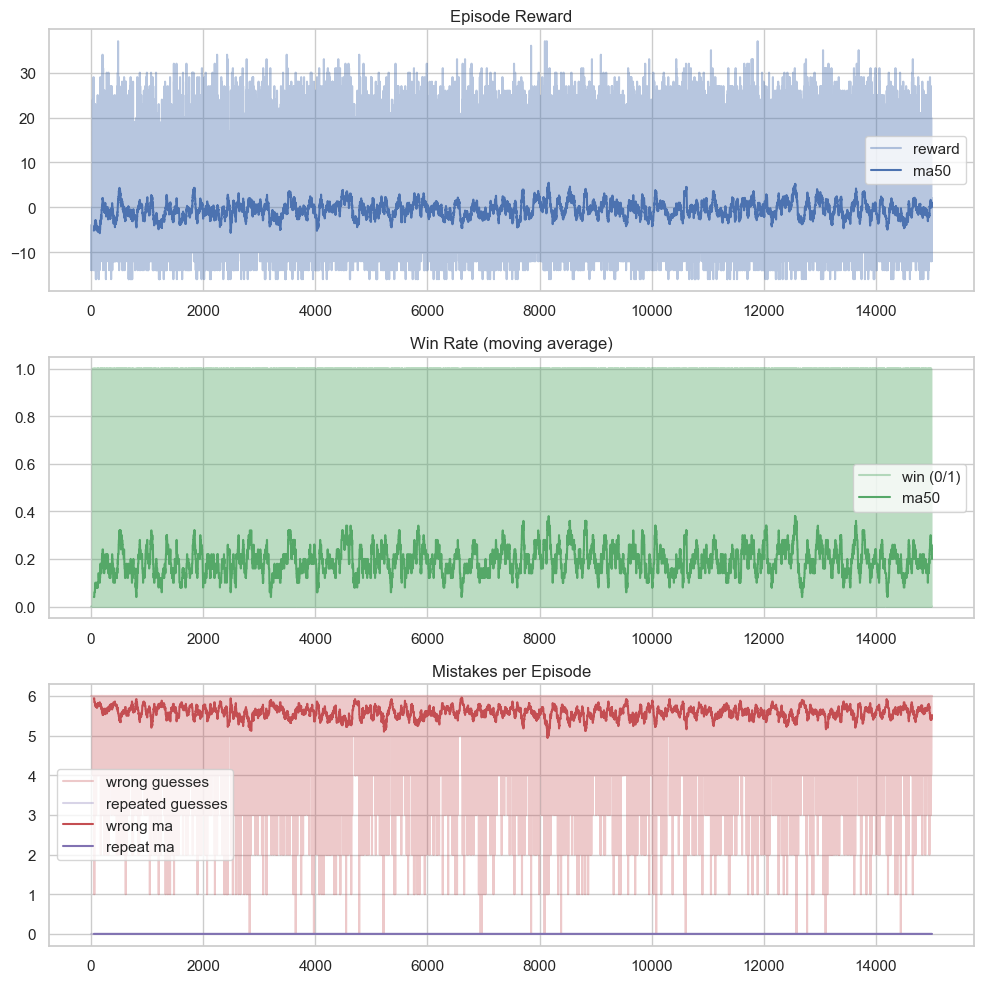

In [67]:
# Training curves and metrics
import numpy as np

WINDOW = 50

def moving_avg(x, w=WINDOW):
    if len(x) < 1:
        return np.array([])
    x = np.array(x, dtype=float)
    if len(x) < w:
        w = len(x)
    return np.convolve(x, np.ones(w)/w, mode='valid')

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(train_rewards, color='#4C72B0', alpha=0.4, label='reward')
axes[0].plot(range(WINDOW-1, WINDOW-1+len(moving_avg(train_rewards))), moving_avg(train_rewards), color='#4C72B0', label=f'ma{WINDOW}')
axes[0].set_title('Episode Reward')
axes[0].legend()

axes[1].plot(train_wins, color='#55A868', alpha=0.4, label='win (0/1)')
axes[1].plot(range(WINDOW-1, WINDOW-1+len(moving_avg(train_wins))), moving_avg(train_wins), color='#55A868', label=f'ma{WINDOW}')
axes[1].set_title('Win Rate (moving average)')
axes[1].legend()

axes[2].plot(train_wrong, color='#C44E52', alpha=0.3, label='wrong guesses')
axes[2].plot(train_repeated, color='#8172B2', alpha=0.3, label='repeated guesses')
axes[2].plot(range(WINDOW-1, WINDOW-1+len(moving_avg(train_wrong))), moving_avg(train_wrong), color='#C44E52', label='wrong ma')
axes[2].plot(range(WINDOW-1, WINDOW-1+len(moving_avg(train_repeated))), moving_avg(train_repeated), color='#8172B2', label='repeat ma')
axes[2].set_title('Mistakes per Episode')
axes[2].legend()

plt.tight_layout()
plt.show()

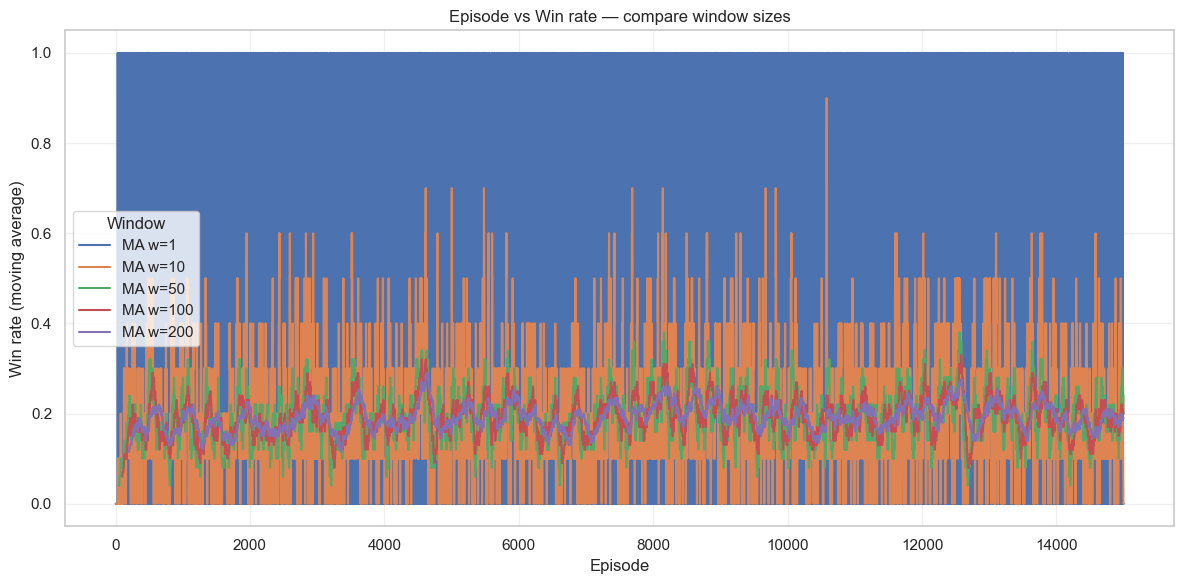

Saved plot to results/episode_vs_accuracy_windows.png


In [68]:
# Plot: Episode vs Win Rate for multiple window sizes
from pathlib import Path
windows = [1, 10, 50, 100, 200]
plt.figure(figsize=(12,6))
plotted = False
for w in windows:
    if len(train_wins) < w:
        print(f"Skipping window {w} (training length {len(train_wins)} < {w})")
        continue
    ma = moving_avg(train_wins, w)
    x = np.arange(w-1, w-1 + len(ma))
    plt.plot(x, ma, label=f"MA w={w}")
    plotted = True
if not plotted:
    print("No windowed series available to plot. Run training first.")
else:
    plt.xlabel('Episode')
    plt.ylabel('Win rate (moving average)')
    plt.title('Episode vs Win rate — compare window sizes')
    plt.legend(title='Window')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    out_dir = Path('results')
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / 'episode_vs_accuracy_windows.png'
    plt.savefig(out_path)
    plt.show()
    print('Saved plot to', out_path)

In [69]:
# Save learned weights (optional)
np.savez_compressed('agent_weights.npz', w=w)
print('Saved agent weights to agent_weights.npz')

Saved agent weights to agent_weights.npz


In [ ]:
# Evaluation on test set

def play_game(word: str):
    guessed = set()
    mask = '_' * len(word)
    lives = MAX_LIVES
    wrongs = 0
    repeats = 0
    total_guesses = 0

    done = False
    while not done:
        probs_vec = hmm_probs_vector(mask, guessed)
        # greedy action
        acts = available_actions(guessed)
        if not acts:
            break
        qvals = [q_value(mask, guessed, lives, probs_vec, a) for a in acts]
        idx = int(np.argmax(qvals))
        a = acts[idx]

        new_mask, guessed, lives, r, done, repeated, wrong = step_env(word, mask, guessed, a, lives)
        total_guesses += 1
        wrongs += int(wrong)
        repeats += int(repeated)
        mask = new_mask

    win = int(mask == word)
    return {
        'win': win,
        'wrong': wrongs,
        'repeated': repeats,
        'guesses': total_guesses,
        'length': len(word)
    }

results = [play_game(w) for w in test_words]

success_rate = np.mean([r['win'] for r in results]) if results else 0.0
total_wrong = int(np.sum([r['wrong'] for r in results]))
total_repeated = int(np.sum([r['repeated'] for r in results]))

final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

print({
    'games': len(results),
    'success_rate': round(success_rate, 4),
    'total_wrong': total_wrong,
    'total_repeated': total_repeated,
    'final_score': round(final_score, 2)
})